# Evaluating the reviews from the two bests Coworking Spaces in Madrid.

In [1]:
import json
import os

# Load the data from the "TalentReviews.json" file
with open(os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/TalentReviews.json")) as f:
    data = json.load(f)

# Print the reviews for the place
print("Reviews for Talent Garden Madrid:")

for review in data.get("result", {}).get("reviews", []):
    print(review.get("text"))

Reviews for Talent Garden Madrid:
Cold and very noisy. Phone booths are open spaces between 4 walls, but no ceiling. Useless
Decided to visit on my week trip to Madrid. At first I was a little skeptical: thought it would be crowded, noisy, and rude staff. BUT I was wrong. This is such a pleasant place as I was welcomed the moment I walked through the door. Marta and Alexa (I think) were so gracious and helped me get situated for the day. Allowed me to sit and purchase a day pass since it wasn't working online. Marta checked on me through the day and informed me of the office space, private rooms for calls, cafe etc. The guy running the cafe was also very pleasant.

The internet was super fast - which is very important. The table/sear selection were comfortable, and the outlets are easily accessible.

I will definitely return on my visits and send people their way.
Thank you for a great experience!
Nice offices walking distance to centre of Madrid.

Clean, Spacious, Modern, plenty of ro

## Sentiment Analysis.

In [2]:
import nltk

# Download the VADER sentiment analysis model from NLTK
nltk.download('vader_lexicon')

# Define the sentiment analysis function
def analyze_sentiment(text):
    from nltk.sentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Load the reviews from the "TalentReviews.json" file
with open(os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/TalentReviews.json")) as f:
    data = json.load(f)

# Classify the reviews as positive, negative, or neutral
for review in data.get("result", {}).get("reviews", []):
    sentiment = analyze_sentiment(review.get("text"))
    print(f"Review sentiment: {sentiment}")

Review sentiment: negative
Review sentiment: positive
Review sentiment: positive
Review sentiment: positive
Review sentiment: positive


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Common concerns or praises in the reviews using the weight of the words.

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess(review):
    # Convert the review into lowercase
    review = review.lower()
    
    # Tokenize the review into individual words
    words = word_tokenize(review)
    
    # Remove punctuation and stopwords
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def preprocess(review):
    if not review:  # Handle empty or None reviews
        return []
    
    # Convert the review into lowercase
    review = review.lower()
    
    # Tokenize the review into individual words
    try:
        words = word_tokenize(review)
    except LookupError as e:
        print("Error in tokenization:", e)
        return []
    
    # Remove punctuation and stopwords
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words


In [5]:
import gensim
import pandas as pd
import nltk
import os
import json

In [6]:
from gensim import corpora, models

# Load reviews from JSON
reviews_path = os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/TalentReviews.json")
with open(reviews_path, "r") as f:
    data = json.load(f)

# Preprocess reviews
reviews = [review.get("text") for review in data.get("result", {}).get("reviews", [])]
preprocessed_reviews = [preprocess(review) for review in reviews]

# Create dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_reviews)
corpus = [dictionary.doc2bow(review) for review in preprocessed_reviews]

# Build LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Extract topic word weights and create DataFrame
word_weights = {
    dictionary[word_id]: weight
    for word_id, weight in lda_model.get_topic_terms(0, topn=len(dictionary))
}
df_talent = pd.DataFrame(word_weights.items(), columns=["word", "weight"])

# Display DataFrame
print(df_talent)


          word    weight
0   definitely  0.010265
1        staff  0.010237
2       member  0.010229
3    recommend  0.010165
4      current  0.010156
..         ...       ...
95       clean  0.009902
96      centre  0.009902
97         bar  0.009902
98     walking  0.009902
99    spacious  0.009902

[100 rows x 2 columns]


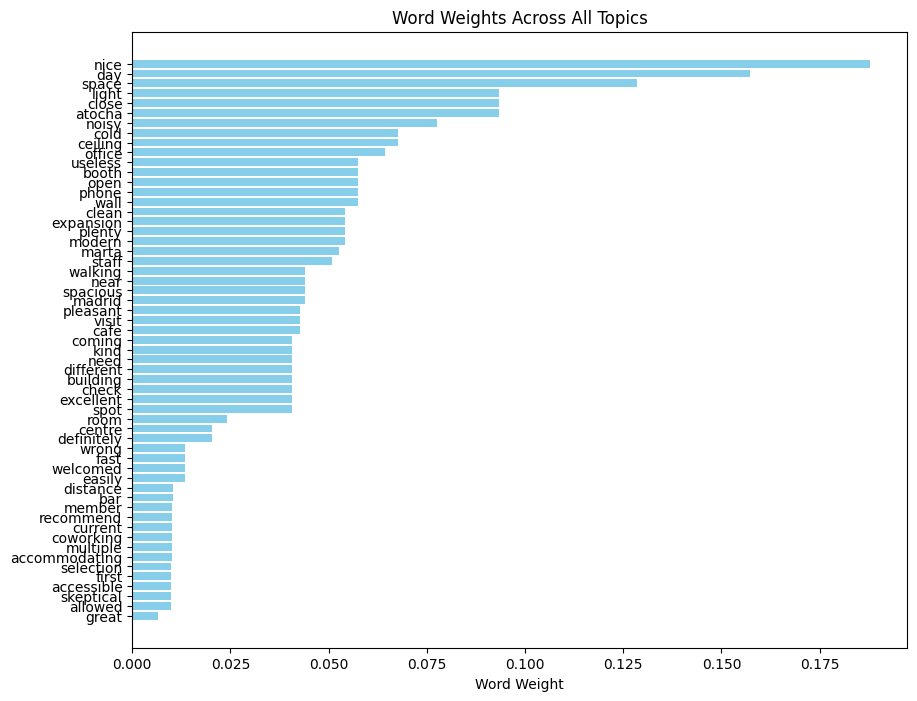

In [7]:
import matplotlib.pyplot as plt

def plot_word_weights(lda_model, dictionary, num_words=10):
    
    # Combine probabilities of each word across all topics
    word_weights = {}
    for topic_id in range(lda_model.num_topics):
        # Extract word probabilities for the current topic
        topic_terms = lda_model.get_topic_terms(topic_id, topn=num_words)
        for word_id, weight in topic_terms:
            word = dictionary[word_id]
            word_weights[word] = word_weights.get(word, 0) + weight

    # Sort words by their combined weights
    sorted_word_weights = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)
    words, weights = zip(*sorted_word_weights)

    # Plot word weights
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), weights, align='center', color='skyblue')
    plt.yticks(range(len(words)), words, fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('Word Weight')
    plt.title('Word Weights Across All Topics')
    plt.show()

# Plot word weights
plot_word_weights(lda_model, dictionary, num_words=10)


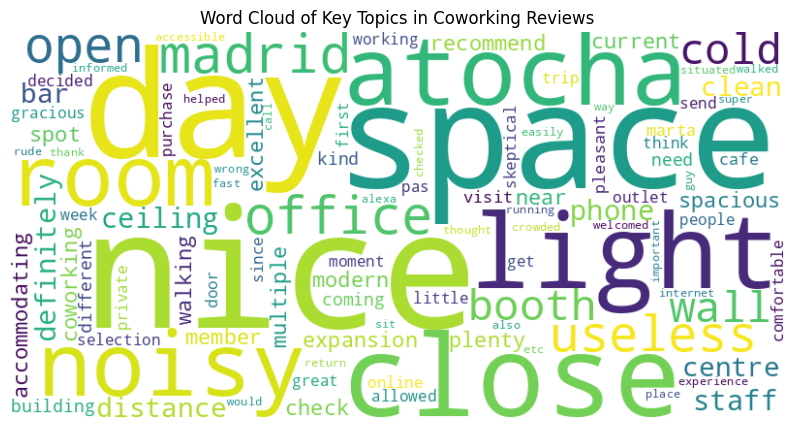

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of word weights from the LDA model
word_weights = {}
for i in range(lda_model.num_topics):  # Iterate through topics
    for word_id, weight in lda_model.get_topic_terms(i, topn=len(dictionary)):
        word = dictionary[word_id]
        if word in word_weights:
            word_weights[word] += weight  # Combine weights across topics
        else:
            word_weights[word] = weight

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    colormap="viridis"
).generate_from_frequencies(word_weights)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Key Topics in Coworking Reviews")
plt.show()


# Evaluating the second best Coworking Space (Freeland)

In [9]:
import json
import os

# Load the data from the "TalentReviews.json" file
with open(os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/FreelandReviews.json")) as f:
    data = json.load(f)

# Print the reviews for the place
print("Reviews for Freeland:")

for review in data.get("result", {}).get("reviews", []):
    print(review.get("text"))

Reviews for Freeland:
The most flexible and conveniently located office in Madrid. The ergonomic seat and large display made me feel better than in a corporate office. Will repeat.
I want to say a huge thank you to the gentleman at the reception today. I had a very bad day, and he helped me and make this bad day a better day. Thank you, this world needs more people kind like you. 🙏🏽
The best co-working I have worked in yet. For a very reasonable price you can rent a very spacious desk and individual space that strike a great balance between privacy and interaction with fellow co-workers. The interior is very well taken care off with enough attention to detail to make you feel comfortable, yet without the frills that would only cause distraction.

Really recommended is the personal approach of the owner Pancho and his team, always showing genuine interest in your ideas and projects and always there to help you out with whatever you need.
I really enjoyed my time working at Freeland and 

## Sentiment Analysis.

In [10]:
import nltk

# Download the VADER sentiment analysis model from NLTK
nltk.download('vader_lexicon')

# Define the sentiment analysis function
def analyze_sentiment(text):
    from nltk.sentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Load the reviews from the "TalentReviews.json" file
with open(os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/FreelandReviews.json")) as f:
    data = json.load(f)

# Classify the reviews as positive, negative, or neutral
for review in data.get("result", {}).get("reviews", []):
    sentiment = analyze_sentiment(review.get("text"))
    print(f"Review sentiment: {sentiment}")

Review sentiment: positive
Review sentiment: positive
Review sentiment: positive
Review sentiment: positive
Review sentiment: positive


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def preprocess(review):
    if not review:  # Handle empty or None reviews
        return []
    
    # Convert the review into lowercase
    review = review.lower()
    
    # Tokenize the review into individual words
    try:
        words = word_tokenize(review)
    except LookupError as e:
        print("Error in tokenization:", e)
        return []
    
    # Remove punctuation and stopwords
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in stopwords.words('english')]
    
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return words


In [12]:
import os
import json
from gensim import corpora, models
import pandas as pd

# Load reviews from JSON
reviews_path = os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/FreelandReviews.json")
with open(reviews_path, "r") as f:
    data = json.load(f)

# Preprocess reviews
reviews = [review.get("text") for review in data.get("result", {}).get("reviews", [])]
preprocessed_reviews = [preprocess(review) for review in reviews]

# Create dictionary and corpus
dictionary = corpora.Dictionary(preprocessed_reviews)
corpus = [dictionary.doc2bow(review) for review in preprocessed_reviews]

# Build LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Extract topic word weights and create DataFrame
word_weights = {
    dictionary[word_id]: weight
    for word_id, weight in lda_model.get_topic_terms(0, topn=len(dictionary))
}
df_freeland = pd.DataFrame(word_weights.items(), columns=["word", "weight"])

# Display DataFrame
print(df_freeland)


           word    weight
0        better  0.007353
1           day  0.007353
2        office  0.007353
3          feel  0.007353
4           bad  0.007353
..          ...       ...
131     looking  0.007353
132      choice  0.007353
133      sector  0.007353
134        take  0.007353
135  constantly  0.007353

[136 rows x 2 columns]


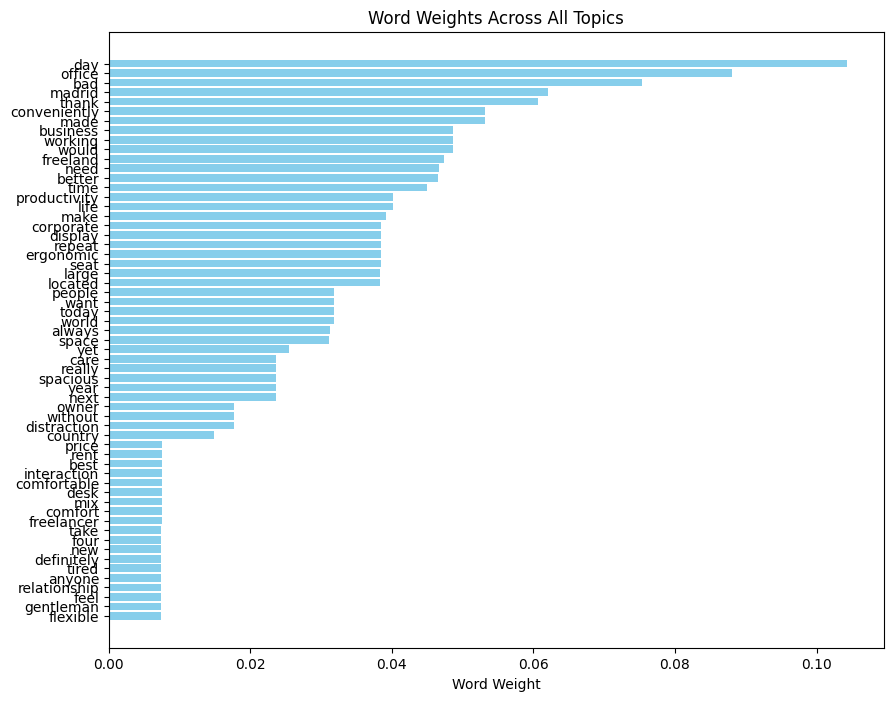

In [13]:
import matplotlib.pyplot as plt

def plot_word_weights(lda_model, dictionary, num_words=10):
    
    # Combine probabilities of each word across all topics
    word_weights = {}
    for topic_id in range(lda_model.num_topics):
        # Extract word probabilities for the current topic
        topic_terms = lda_model.get_topic_terms(topic_id, topn=num_words)
        for word_id, weight in topic_terms:
            word = dictionary[word_id]
            word_weights[word] = word_weights.get(word, 0) + weight

    # Sort words by their combined weights
    sorted_word_weights = sorted(word_weights.items(), key=lambda x: x[1], reverse=True)
    words, weights = zip(*sorted_word_weights)

    # Plot word weights
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(words)), weights, align='center', color='skyblue')
    plt.yticks(range(len(words)), words, fontsize=10)
    plt.gca().invert_yaxis()
    plt.xlabel('Word Weight')
    plt.title('Word Weights Across All Topics')
    plt.show()

# Plot word weights
plot_word_weights(lda_model, dictionary, num_words=10)


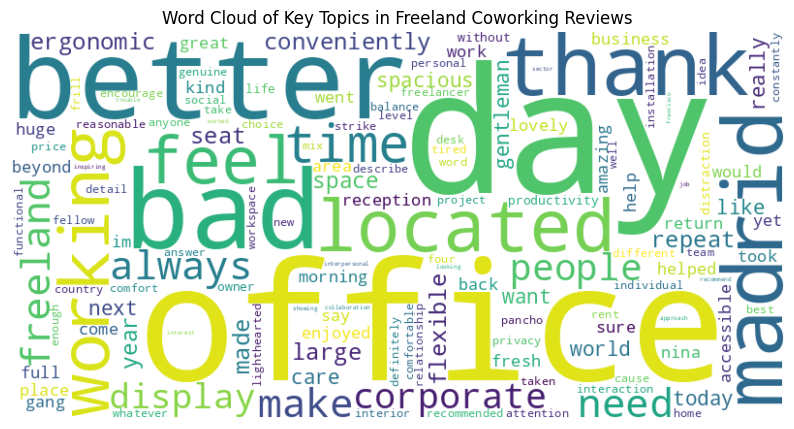

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary of word weights from the LDA model
word_weights = {}
for i in range(lda_model.num_topics):  # Iterate through topics
    for word_id, weight in lda_model.get_topic_terms(i, topn=len(dictionary)):
        word = dictionary[word_id]
        if word in word_weights:
            word_weights[word] += weight  # Combine weights across topics
        else:
            word_weights[word] = weight

# Generate the word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color="white", 
    colormap="viridis"
).generate_from_frequencies(word_weights)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Key Topics in Freeland Coworking Reviews")
plt.show()


### The common words that was used in the reviews for each place.

In [15]:
import pandas as pd

# Merge the two DataFrames on the 'word' column
merged_df = df_freeland.merge(df_talent, on='word', how='inner')

# Rename the columns
merged_df.columns = ['word', 'weight_freeland', 'weight_talent']

# Create a new column for the differences between the weights
merged_df['weight_difference'] = abs(merged_df['weight_freeland'] - merged_df['weight_talent'])

# Sort the DataFrame by the 'weight_difference' column in descending order
merged_df = merged_df.sort_values(by='weight_difference', ascending=True)

# Display the DataFrame
print(merged_df)


           word  weight_freeland  weight_talent  weight_difference
4      spacious         0.007353       0.009902           0.002549
5         would         0.007353       0.009972           0.002619
7         thank         0.007353       0.009980           0.002627
12       return         0.007353       0.009986           0.002633
18  comfortable         0.007353       0.009988           0.002635
19   accessible         0.007353       0.009989           0.002636
1        office         0.007353       0.009992           0.002639
13        place         0.007353       0.009997           0.002644
11       helped         0.007353       0.009997           0.002644
3        madrid         0.007353       0.010001           0.002648
2       working         0.007353       0.010004           0.002651
8        people         0.007353       0.010011           0.002658
17        great         0.007353       0.010016           0.002663
10         kind         0.007353       0.010070           0.00

In [16]:
# Save DataFrame to CSV file
merged_df.to_csv('merged_word_weight.csv', index=False)


## The Words that is most import in both reviews.

In [21]:
import pandas as pd

# Load the CSV file
merged_df = os.path.join(os.getcwd(), "/workspaces/Coworking/src/results/merged_data.csv")
data = pd.read_csv(merged_df)

print(data)

            word  weight_freeland  weight_talent  weight_difference
0          great         0.011486       0.007353           0.004133
1          owner         0.011486       0.007353           0.004133
2       interior         0.011486       0.007353           0.004133
3    distraction         0.011487       0.007353           0.004134
4        project         0.011487       0.007353           0.004134
..           ...              ...            ...                ...
131     spacious         0.021961       0.007353           0.014608
132        space         0.021964       0.007353           0.014611
133       really         0.021965       0.007353           0.014612
134         time         0.022003       0.007353           0.014651
135       always         0.032405       0.007353           0.025052

[136 rows x 4 columns]


In [31]:
most_important_words = data.sort_values(by='weight_difference', ascending=False).tail(10)

print(most_important_words)

          word  weight_freeland  weight_talent  weight_difference
9         team         0.011491       0.007353           0.004138
8         best         0.011491       0.007353           0.004138
7         idea         0.011490       0.007353           0.004137
6  recommended         0.011489       0.007353           0.004136
5       worked         0.011487       0.007353           0.004134
4      project         0.011487       0.007353           0.004134
3  distraction         0.011487       0.007353           0.004134
2     interior         0.011486       0.007353           0.004133
1        owner         0.011486       0.007353           0.004133
0        great         0.011486       0.007353           0.004133


In [32]:
most_important_words.to_csv('most_important_words.csv', index=False)


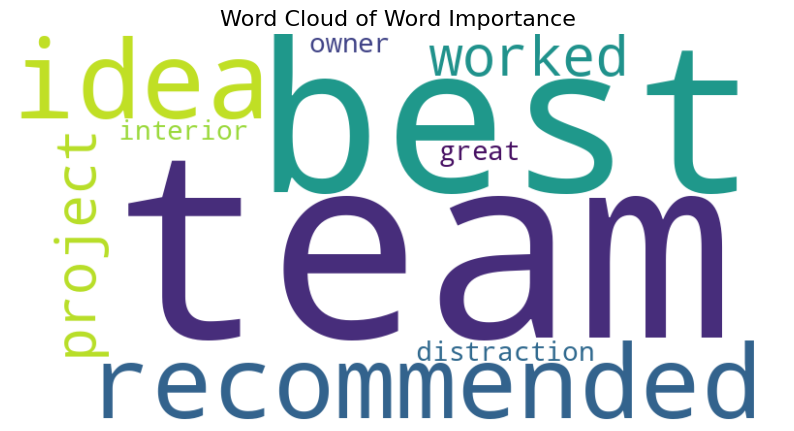

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(most_important_words['word'], most_important_words['weight_difference'])))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Word Importance', fontsize=16)
plt.show()
